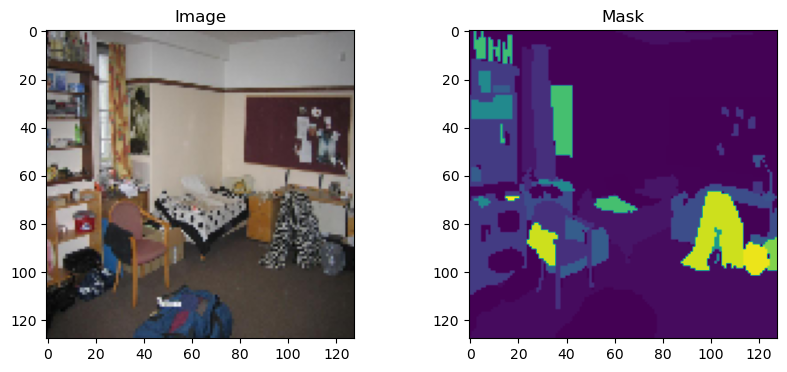

total number of classes used: 151
Missing keys (not in checkpoint but expected by model): {'final_layer.1.running_var', 'final_layer.1.num_batches_tracked', 'final_layer.0.weight', 'final_layer.1.weight', 'final_layer.0.bias', 'final_layer.1.bias', 'final_layer.1.running_mean'}
Extra keys (in checkpoint but not expected by model): set()


In [6]:
import os
import numpy as np
import warnings
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from pycocotools.coco import COCO
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2
import json
from panopticapi.utils import rgb2id

BATCH_SIZE = 8
IMG_WIDTH = 128
IMG_HEIGHT = 128


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

ADEK_ROOT = './ADEK'
IMG_DIR_TRAIN = os.path.join(ADEK_ROOT, 'images', 'training')
ANN_DIR_TRAIN = os.path.join(ADEK_ROOT, 'annotations', 'training')

IMG_DIR_VAL = os.path.join(ADEK_ROOT, 'images', 'validation')
ANN_DIR_VAL = os.path.join(ADEK_ROOT, 'annotations', 'validation')

# Use the dataset class from the previous snippet, for example:
class ADE20KSegmentationDataset(Dataset):
    def __init__(self, objectinfo_txt, img_dir, ann_dir, transforms=None, img_size=(128, 128)):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        self.img_width, self.img_height = img_size

        # Load categories from objectinfo150.txt
        with open(objectinfo_txt, 'r') as f:
            # Assuming each non-empty line corresponds to one category name.
            categories = [line.strip() for line in f if line.strip()]
        self.categories = categories
        # For ADE20K, the segmentation mask pixel values represent the category id.
        # Create a mapping from category id (here, simply the index) to label id.
        self.cat2label = {i: i for i in range(len(categories))}

        # List all image files (adjust extensions as needed)
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_filename = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            raise FileNotFoundError(f"Could not find {img_path}")
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        # Assume the annotation has the same base name with a .png extension
        ann_filename = os.path.splitext(img_filename)[0] + '.png'
        ann_path = os.path.join(self.ann_dir, ann_filename)
        mask = cv2.imread(ann_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Could not find {ann_path}")
        
        # Resize image and mask
        image_rgb = cv2.resize(image_rgb, (self.img_width, self.img_height), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
        
        if self.transforms:
            image_rgb = self.transforms(image_rgb)
        
        mask = torch.from_numpy(mask).long()
        return image_rgb, mask

train_dataset = ADE20KSegmentationDataset(
    objectinfo_txt=os.path.join(ADEK_ROOT, 'objectInfo150.txt'),
    img_dir=os.path.join(ADEK_ROOT, 'images', 'training'),
    ann_dir=os.path.join(ADEK_ROOT, 'annotations', 'training'),
    transforms=ToTensor(),
    img_size=(128, 128)
)

val_dataset = ADE20KSegmentationDataset(
    objectinfo_txt=os.path.join(ADEK_ROOT, 'objectInfo150.txt'),
    img_dir=os.path.join(ADEK_ROOT, 'images', 'validation'),
    ann_dir=os.path.join(ADEK_ROOT, 'annotations', 'validation'),
    transforms=ToTensor(),
    img_size=(128, 128)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

import random
import matplotlib.pyplot as plt
import numpy as np

def visualize_random_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]
    if isinstance(image, torch.Tensor):
        # Permute to [H, W, C]
        image_np = image.permute(1, 2, 0).cpu().numpy()
        # If it's in range [0,1], scale for display:
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype(np.uint8)
    else:
        image_np = image
        
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask)
    plt.title("Mask")

    plt.show()

visualize_random_sample(train_dataset)
def mean_iou(y_pred, y_true, num_classes, smooth=1e-6):
    
    y_pred = torch.softmax(y_pred/0.5, dim=1)
    y_pred = torch.argmax(y_pred, dim=1)

    iou_list = []

    for class_id in range(num_classes):
        intersection = torch.sum((y_pred == class_id) & (y_true == class_id))
        union = torch.sum((y_pred == class_id) | (y_true == class_id))
        
        if union == 0:
            continue 
        
        iou = (intersection.float() + smooth) / (union.float() + smooth)
        iou_list.append(iou)


    return torch.mean(torch.stack(iou_list))
import torch
import torch.nn as nn
import torch.nn.functional as F


class Mask2FormerAttention(nn.Module):
    def __init__(self, channels, size):
        super(Mask2FormerAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.query = nn.Linear(channels, channels)
        self.key = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)
        self.mask = None  
        self.norm = nn.LayerNorm([channels])

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        if channels != self.channels:
            raise ValueError("Input channel size does not match initialized channel size.")
        
        x = x.view(batch_size, channels, height * width).permute(0, 2, 1)  

        Q = self.query(x)  
        K = self.key(x)    
        V = self.value(x)  

        scores = torch.matmul(Q, K.transpose(-2, -1))  
        scores = scores / (self.channels ** 0.5)       

        if self.mask is None or self.mask.size(-1) != height * width:
            binary_mask = torch.randint(0, 2, (batch_size, height, width), device=x.device)
            binary_mask = binary_mask.view(batch_size, -1)  
            processed_mask = torch.where(binary_mask > 0.5, torch.tensor(0.0, device=x.device), torch.tensor(-float('inf'), device=x.device))
            self.mask = processed_mask.unsqueeze(1).expand(-1, height * width, -1) 
            
        scores = scores + self.mask

        attention_weights = F.softmax(scores, dim=-1)  
        attention_output = torch.matmul(attention_weights, V) 
        attention_output = attention_output + x  
        attention_output = self.norm(attention_output)
        
        return attention_output.view(batch_size, channels, height, width)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
            nn.BatchNorm2d(out_channels)
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
            nn.BatchNorm2d(out_channels)
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x
    
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = Mask2FormerAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = Mask2FormerAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = Mask2FormerAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)
        
        self.dropout = nn.Dropout(0.3)
        
        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = Mask2FormerAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = Mask2FormerAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = Mask2FormerAttention(64, 64)
        self.norm = nn.LayerNorm([64, 128, 128])
        # self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)
        self.final_layer = nn.Sequential(
                                nn.Conv2d(64, c_out, kernel_size=1),
                                nn.BatchNorm2d(c_out), 
                                nn.ReLU()  
                            )

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        x = self.dropout(x)
        x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        x = self.dropout(x)
        x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        x = self.self_attention6(x)
        x = self.norm(x)
        # output = self.output_conv(x)
        output = self.final_layer(x)
        return output

#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), 'checkpoint_ade.pth')
# from segmentation_models_pytorch import Unet

# pretrained_model = Unet(encoder_name="mit_b5", encoder_weights="imagenet",in_channels=3,classes=len(train_dataset.cat2label))
# pretrained_weights = pretrained_model.state_dict()
import torch.backends.cudnn as cudnn
# from torch_lr_finder import LRFinder

c_in = 3  # input channel 3 for RGB
c_out = len(train_dataset.cat2label)
print(f'total number of classes used: {c_out}')
if torch.cuda.device_count() > 1:
    device1 = torch.device("cuda:0")
    device2 = torch.device("cuda:1")
else:
    raise RuntimeError("Multiple GPUs are required.")

model = UNet(c_in, c_out)
# checkpoint = torch.load('checkpoint.pth')
# modified_state_dict = {key.replace('module.', ''): value for key, value in checkpoint.items()}
# model.load_state_dict(modified_state_dict)
model_dict = model.state_dict()
checkpoint = torch.load('checkpoint_pan.pth')
modified_state_dict = {key.replace('module.', ''): value for key, value in checkpoint.items()}
pretrained_dict = {k: v for k, v in modified_state_dict.items() if k in model_dict and model_dict[k].shape == v.shape}

filtered_state_dict = {k: v for k, v in modified_state_dict.items() if not k.startswith('final_layer.')}

model.load_state_dict(filtered_state_dict, strict=False)
#model_dict.update(pretrained_dict)

missing_keys = set(model.state_dict().keys()) - set(filtered_state_dict.keys())

# Find keys that are in the checkpoint but not in the model's state dict
extra_keys = set(filtered_state_dict.keys()) - set(model.state_dict().keys())

# Print the differences
print("Missing keys (not in checkpoint but expected by model):", missing_keys)
print("Extra keys (in checkpoint but not expected by model):", extra_keys)

#model.load_state_dict(model_dict)

# def map_pretrained_to_check(pretrained_dict, custom_dict):
#     mapped_weights = {}
#     for key in pretrained_dict:
#         if key.startswith("encoder.conv1"):
#             new_key = key.replace("encoder.conv1", "initial_conv.conv_block.0")
#             if new_key in custom_dict:
#                 mapped_weights[new_key] = pretrained_dict[key]
#     return mapped_weights

# mapped_weights = map_pretrained_to_check(pretrained_weights, modified_state_dict)
# modified_state_dict.update(mapped_weights)
    
# model.load_state_dict(modified_state_dict)


